In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/Aditya1Jhaveri/Colorectal-Cancer-Tissue-Classification.git

Cloning into 'Colorectal-Cancer-Tissue-Classification'...
remote: Enumerating objects: 32896, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 32896 (delta 4), reused 2 (delta 0), pack-reused 32887 (from 1)
Receiving objects: 100% (32896/32896), 2.85 GiB | 43.00 MiB/s, done.
Resolving deltas: 100% (190/190), done.
Updating files: 100% (51244/51244), done.


In [3]:
import tensorflow as tf
from keras.applications import ResNet101V2
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization,Flatten
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import preprocessing
from keras.utils import to_categorical



# Set your data directories and parameters
train_data_dir = '/content/Colorectal-Cancer-Tissue-Classification/CRC_NEW_DATASET/train'
test_data_dir = '/content/Colorectal-Cancer-Tissue-Classification/CRC_NEW_DATASET/test'
val_data_dir = '/content/Colorectal-Cancer-Tissue-Classification/CRC_NEW_DATASET/validation'


img_width, img_height = 224, 224
batch_size = 16
base_learning_rate = 0.001  # Adjust as needed

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    fill_mode='reflect'
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    fill_mode='reflect'
)

# Data preprocessing for test
test_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Load the data using data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  # Automatically one-hot encodes labels
    shuffle=True  # Shuffle the data
)
print(f"Found {train_generator.samples} images belonging to {len(train_generator.class_indices)} classes in train dataset.")

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  # Automatically one-hot encodes labels
    shuffle=False  # No need to shuffle test data
)
print(f"Found {test_generator.samples} images belonging to {len(test_generator.class_indices)} classes in test dataset.")

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  # Automatically one-hot encodes labels
    shuffle=False  # No need to shuffle test data
)
print(f"Found {val_generator.samples} images belonging to {len(val_generator.class_indices)} classes in validation dataset.")


Found 12907 images belonging to 9 classes.
Found 12907 images belonging to 9 classes in train dataset.
Found 2768 images belonging to 9 classes.
Found 2768 images belonging to 9 classes in test dataset.
Found 2765 images belonging to 9 classes.
Found 2765 images belonging to 9 classes in validation dataset.


In [ ]:
# Load the ResNet101V2 model
base_model = ResNet101V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))


# Add your custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = Dropout(0.3)(x)

x = Dense(64)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)

predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


base_model.trainable = True

set_trainable = False

for layer in base_model.layers:
  if layer.name == 'conv4_block1_preact_bn':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in base_model.layers:
  print(layer.name,layer.trainable)


171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
input_layer False
conv1_pad False
conv1_conv False
pool1_pad False
pool1_pool False
conv2_block1_preact_bn False
conv2_block1_preact_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_pad False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_out False
conv2_block2_preact_bn False
conv2_block2_preact_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_pad False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_out False
conv2_block3_preact_bn False
conv2_block3_preact_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_pad False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
max_pooling2d False
conv2_bl

In [ ]:
model.summary();

In [ ]:
# Compile the model after unfreezing layers for fine-tuning
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),  # Use categorical_crossentropy
    optimizer=RMSprop(learning_rate=base_learning_rate/10),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]  # Use CategoricalAccuracy
)

# Set up callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping and learning rate reduction
history = model.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs=25,
    validation_data=val_generator,
    validation_steps = len(val_generator),
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/25
807/807 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9338 - loss: 0.2791

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


807/807 ━━━━━━━━━━━━━━━━━━━━ 391s 414ms/step - accuracy: 0.9338 - loss: 0.2791 - val_accuracy: 0.9863 - val_loss: 0.0524 - learning_rate: 1.0000e-04
Epoch 2/25
807/807 ━━━━━━━━━━━━━━━━━━━━ 297s 368ms/step - accuracy: 0.9531 - loss: 0.1769 - val_accuracy: 0.9732 - val_loss: 0.0818 - learning_rate: 1.0000e-04
Epoch 3/25
807/807 ━━━━━━━━━━━━━━━━━━━━ 301s 373ms/step - accuracy: 0.9638 - loss: 0.1398 - val_accuracy: 0.9870 - val_loss: 0.0426 - learning_rate: 1.0000e-04
Epoch 4/25
807/807 ━━━━━━━━━━━━━━━━━━━━ 303s 375ms/step - accuracy: 0.9721 - loss: 0.1022 - val_accuracy: 0.9917 - val_loss: 0.0257 - learning_rate: 1.0000e-04
Epoch 5/25
807/807 ━━━━━━━━━━━━━━━━━━━━ 337s 417ms/step - accuracy: 0.9759 - loss: 0.0880 - val_accuracy: 0.9899 - val_loss: 0.0332 - learning_rate: 1.0000e-04
Epoch 6/25
807/807 ━━━━━━━━━━━━━━━━━━━━ 305s 377ms/step - accuracy: 0.9817 - loss: 0.0665 - val_accuracy: 0.9978 - val_loss: 0.0106 - learning_rate: 1.0000e-04
Epoch 7/25
807/807 ━━━━━━━━━━━━━━━━━━━━ 305s 378ms/

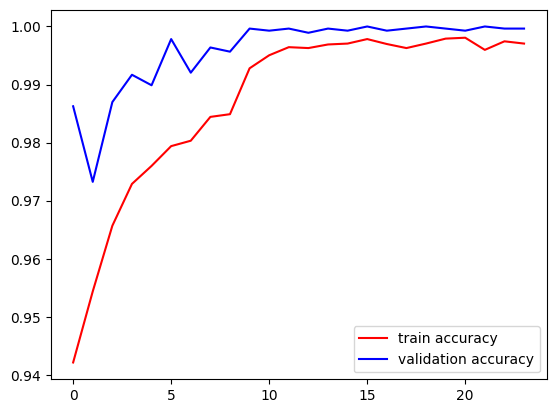

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train accuracy')
plt.plot(history.history['val_accuracy'],color='blue',label='validation accuracy')
plt.legend()
plt.show()

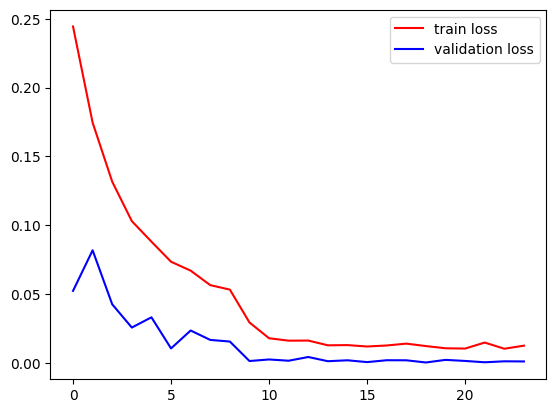

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.plot(history.history['loss'], color='red', label='train loss')
plt.plot(history.history['val_loss'], color='blue', label='validation loss')
plt.legend()
plt.show()

In [ ]:
train_loss, train_accuracy = model.evaluate(train_generator)

print(f'Train accuracy: {train_accuracy:.4f}')

807/807 ━━━━━━━━━━━━━━━━━━━━ 225s 279ms/step - accuracy: 0.9995 - loss: 0.0019
Train accuracy: 0.9995


In [ ]:
# Evaluate the model on the test data using the test generator
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test accuracy: {test_accuracy:.4f}')

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


173/173 ━━━━━━━━━━━━━━━━━━━━ 45s 262ms/step - accuracy: 0.9998 - loss: 0.0015
Test accuracy: 0.9989


In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd


image_dir = "/content/Colorectal-Cancer-Tissue-Classification/CRC_NEW_DATASET/test"

# Map integer class labels back to string class names
index_to_class = {v: k for k, v in test_generator.class_indices.items()}

# Build DataFrame with relative paths and string class labels
df = pd.DataFrame({
    "filename": test_generator.filenames,
    "class": [index_to_class[i] for i in test_generator.classes]
})

# Setup StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

eval_scores = []
fold_no = 1

for _, val_idx in skf.split(df["filename"], df["class"]):
    val_df = df.iloc[val_idx].reset_index(drop=True)

    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory=image_dir,
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        class_mode="categorical",
        batch_size=16,
        shuffle=False,
        color_mode='rgb'
    )

    # Evaluate the model
    scores = model.evaluate(val_generator, verbose=0)

    print(f"Fold {fold_no} Accuracy (evaluation only): {scores[1]*100:.2f}%")
    eval_scores.append(scores[1]*100)
    fold_no += 1

# Final results
print("\nCross-validation-like evaluation:")
print(f"Accuracies: {eval_scores}")
print(f"Mean Accuracy: {np.mean(eval_scores):.2f}% (+/- {np.std(eval_scores):.2f}%)")


Found 554 validated image filenames belonging to 9 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Fold 1 Accuracy (evaluation only): 99.82%
Found 554 validated image filenames belonging to 9 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Fold 2 Accuracy (evaluation only): 99.82%
Found 554 validated image filenames belonging to 9 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Fold 3 Accuracy (evaluation only): 100.00%
Found 553 validated image filenames belonging to 9 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Fold 4 Accuracy (evaluation only): 100.00%
Found 553 validated image filenames belonging to 9 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Fold 5 Accuracy (evaluation only): 100.00%

Cross-validation-like evaluation:
Accuracies: [99.8194932937622, 99.8194932937622, 100.0, 100.0, 100.0]
Mean Accuracy: 99.93% (+/- 0.09%)


173/173 ━━━━━━━━━━━━━━━━━━━━ 55s 275ms/step


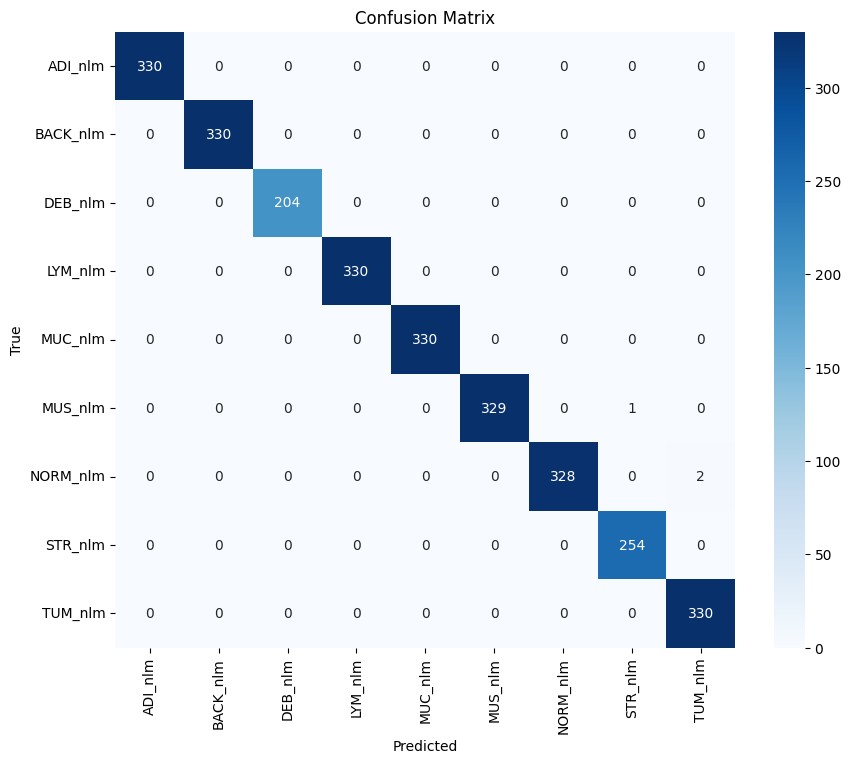

      Class  Precision    Recall  F1 Score
0   ADI_nlm   1.000000  1.000000  1.000000
1  BACK_nlm   1.000000  1.000000  1.000000
2   DEB_nlm   1.000000  1.000000  1.000000
3   LYM_nlm   1.000000  1.000000  1.000000
4   MUC_nlm   1.000000  1.000000  1.000000
5   MUS_nlm   1.000000  0.996970  0.998483
6  NORM_nlm   1.000000  0.993939  0.996960
7   STR_nlm   0.996078  1.000000  0.998035
8   TUM_nlm   0.993976  1.000000  0.996979


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Make Predictions
y_pred = model.predict(test_generator)

# Convert Predictions and True Labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_generator.classes

# Create the Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)


# Create a dictionary to map class indices to class names
class_indices = test_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}


# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_true_classes, y_pred_classes, average=None)
recall = recall_score(y_true_classes, y_pred_classes, average=None)
f1 = f1_score(y_true_classes, y_pred_classes, average=None)

# Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Create a list of class names
class_names_list = [class_names[i] for i in range(len(class_indices))]

# Create a DataFrame to organize the results
results_df = pd.DataFrame({
    'Class': class_names_list,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

# Print the results table
print(results_df)


In [ ]:
# Save the model with custom layers and weights
model.save('CRC_ResNet101V2_model.h5')

In [5]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Load the model
new_model = tf.keras.models.load_model('/content/drive/MyDrive/CRC_ResNet101V2_model.h5')


In [ ]:
train_loss, train_accuracy = new_model.evaluate(train_generator)

print(f'Train accuracy: {train_accuracy:.4f}')

807/807 ━━━━━━━━━━━━━━━━━━━━ 223s 265ms/step - accuracy: 0.9998 - loss: 8.9579e-04
Train accuracy: 0.9998


In [ ]:
# Evaluate the model on the test data using the test generator
test_loss, test_accuracy = new_model.evaluate(test_generator)

print(f'Test accuracy: {test_accuracy:.4f}')

173/173 ━━━━━━━━━━━━━━━━━━━━ 44s 253ms/step - accuracy: 0.9998 - loss: 0.0011
Test accuracy: 0.9989


173/173 ━━━━━━━━━━━━━━━━━━━━ 56s 289ms/step


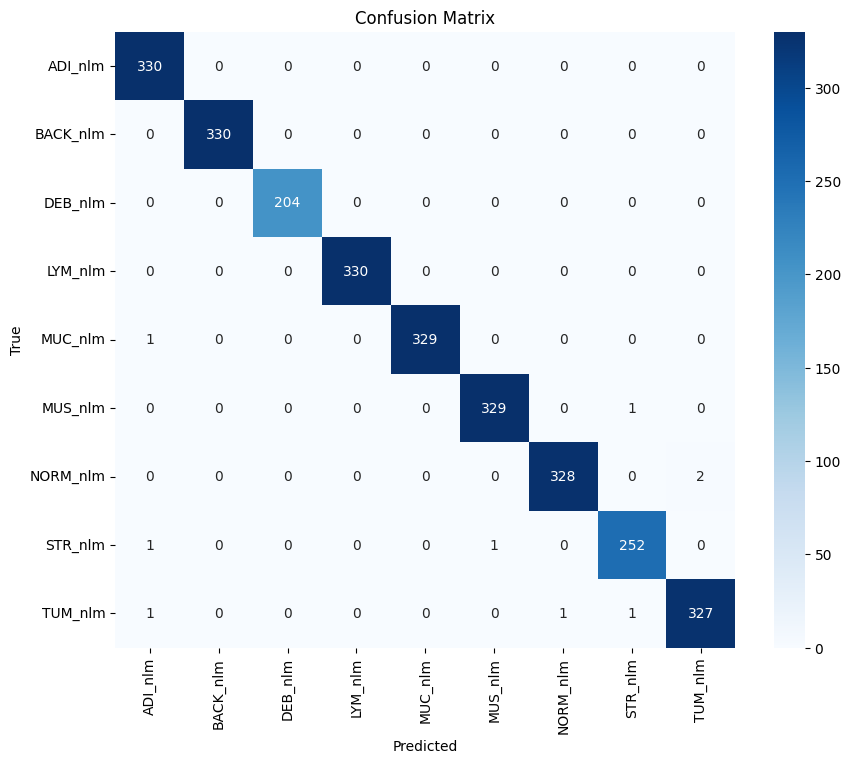

      Class  Precision    Recall  F1 Score
0   ADI_nlm   0.990991  1.000000  0.995475
1  BACK_nlm   1.000000  1.000000  1.000000
2   DEB_nlm   1.000000  1.000000  1.000000
3   LYM_nlm   1.000000  1.000000  1.000000
4   MUC_nlm   1.000000  0.996970  0.998483
5   MUS_nlm   0.996970  0.996970  0.996970
6  NORM_nlm   0.996960  0.993939  0.995448
7   STR_nlm   0.992126  0.992126  0.992126
8   TUM_nlm   0.993921  0.990909  0.992413


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Make Predictions
y_pred = new_model.predict(test_generator)

# Convert Predictions and True Labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_generator.classes

# Create the Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)


# Create a dictionary to map class indices to class names
class_indices = test_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}


# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_true_classes, y_pred_classes, average=None)
recall = recall_score(y_true_classes, y_pred_classes, average=None)
f1 = f1_score(y_true_classes, y_pred_classes, average=None)

# Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Create a list of class names
class_names_list = [class_names[i] for i in range(len(class_indices))]

# Create a DataFrame to organize the results
results_df = pd.DataFrame({
    'Class': class_names_list,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

# Print the results table
print(results_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


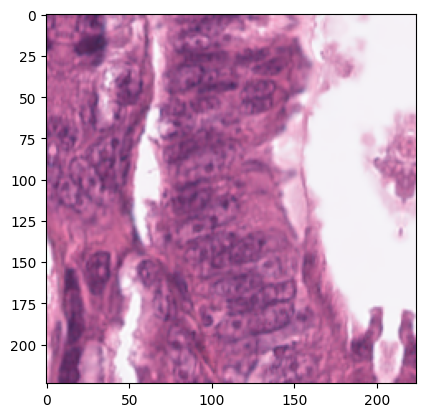

Predicted Class: TUM_nlm
Cancerous


In [8]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Define the determine_cancerous function
def determine_cancerous(class_name):
    cancerous_classes = {
        'ADI_nlm':False,
        'BACK_nlm':False,
        'DEB_nlm':False,
        'LYM_nlm': False,
        'MUC_nlm':False,
        'MUS_nlm': False,
        'NORM_nlm': False,
        'STR_nlm': True,
        'TUM_nlm': True,
    }

    return cancerous_classes.get(class_name, None)

# Load and preprocess a sample image
image_path = '/content/Colorectal-Cancer-Tissue-Classification/CRC_NEW_DATASET/test/TUM_nlm/TUM-TCGA-AEKWGDVR_aug_1.png'
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # rescale

# Make a prediction
prediction = new_model.predict(img_array)

# Convert the prediction to class name
class_index = np.argmax(prediction)
class_name = list(test_generator.class_indices.keys())[class_index]

plt.imshow(img)
plt.show()

# Print the predicted class name
print(f'Predicted Class: {class_name}')

# Determine if it's cancerous or not
is_cancerous = determine_cancerous(class_name)


# Print whether it's cancerous or not
if is_cancerous is not None:
    if is_cancerous:
        print('Cancerous')
    else:
        print('Non-cancerous')
else:
    print('Class not found in dictionary')


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image

#Preprocess image
def preprocess_image(img_path, target_size=(224,224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0), img

# Grad-CAM function
def make_gradcam_heatmap(model, img_array, last_conv_layer_name="conv5_block3_out"):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        pred_output = predictions[:, pred_index]

    grads = tape.gradient(pred_output, conv_outputs)

    # Global average pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Weight conv maps with pooled grads
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    # Normalize
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

#Overlay heatmap on original image
def display_gradcam(img_path, model = new_model, last_conv_layer_name="conv5_block3_out", alpha=0.4):
    img_array, original_img = preprocess_image(img_path)

    heatmap = make_gradcam_heatmap(model, img_array, last_conv_layer_name)

    # Resize heatmap to match image
    heatmap = cv2.resize(heatmap, (original_img.size[0], original_img.size[1]))
    heatmap = np.uint8(255 * heatmap)

    # Apply colormap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(np.array(original_img), 1-alpha, heatmap, alpha, 0)

    # Show results
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(original_img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM")
    plt.axis("off")
    plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


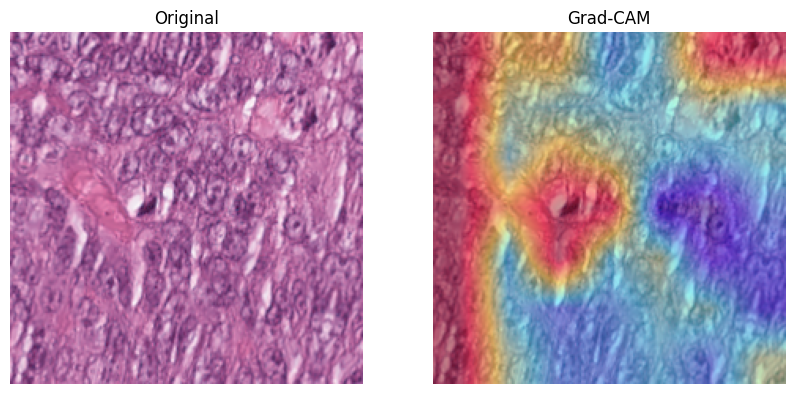

In [21]:
img_path = "/content/Colorectal-Cancer-Tissue-Classification/CRC_NEW_DATASET/test/TUM_nlm/TUM-TCGA-ADFSWFVW_aug_1.png"

display_gradcam(img_path)


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Define the determine_cancerous function
def determine_cancerous(class_name):
    cancerous_classes = {
        'ADI_nlm': False,
        'BACK_nlm': False,
        'DEB_nlm': False,
        'LYM_nlm': False,
        'MUC_nlm': False,
        'MUS_nlm': False,
        'NORM_nlm': False,
        'STR_nlm': True,
        'TUM_nlm': True,
    }
    return cancerous_classes.get(class_name, None)

#Grad-CAM Heatmap
def make_gradcam_heatmap(model, img_array, last_conv_layer_name="conv5_block3_out"):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        pred_output = predictions[:, pred_index]

    grads = tape.gradient(pred_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), predictions.numpy()

#Display function
def display_gradcam_from_img(img, model=new_model, class_indices=test_generator.class_indices, last_conv_layer_name="conv5_block3_out", alpha=0.4):
    # Convert PIL -> array
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Compute Grad-CAM
    heatmap, preds = make_gradcam_heatmap(model, img_array, last_conv_layer_name)

    # Predicted class
    class_index = np.argmax(preds)
    class_name = list(class_indices.keys())[class_index]
    predicted_accuracy = preds[0][class_index] * 100
    is_cancerous = determine_cancerous(class_name)

    # Resize heatmap to image
    w, h = img.size
    original_img = np.array(img)
    heatmap = cv2.resize(heatmap, (w, h))
    heatmap = np.uint8(255 * heatmap)

    # Overlay heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(original_img, 1-alpha, heatmap, alpha, 0)

    # Show results
    plt.figure(figsize=(14,6))

    plt.subplot(1,3,1)
    plt.imshow(original_img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM")
    plt.axis("off")
    plt.show()

    # Print results
    print(f"Predicted Class: {class_name}")
    print(f"Predicted Accuracy: {predicted_accuracy:.2f}%")

    if is_cancerous is not None:
        print("Cancerous" if is_cancerous else "Non-cancerous")
    else:
        print("Class not found in dictionary")


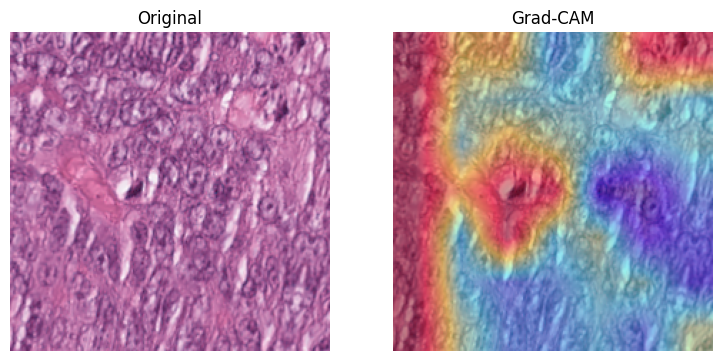

Predicted Class: TUM_nlm
Predicted Accuracy: 100.00%
Cancerous


In [27]:

img_path = "/content/Colorectal-Cancer-Tissue-Classification/CRC_NEW_DATASET/test/TUM_nlm/TUM-TCGA-ADFSWFVW_aug_1.png"
img = image.load_img(img_path, target_size=(224, 224))


display_gradcam_from_img(img)